<div style="display: flex; align-items: center; justify-content: space-between; background-color: #1e355f; padding: 30px;">
    <div>
        <h1 style="color: white; text-align: center; font-weight: bold;">Datos No Estructurados: IMAGEN</h1>
        <h2 style="color: white; text-align: center;">Clasificador de Melanoma</h2>
    </div>

</div>

<div style="padding: 5px;">
    <h3 style="color: #1e355f; font-weight: bold;">Realizado por:</h3>
</div>

- Álvaro Ezquerro Pérez
- María Calvo de Mora Román
- Celia Quiles Alemañ


In [23]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import pickle
import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Own modules
notebook_path = os.getcwd()
if notebook_path not in sys.path:
    sys.path.append(notebook_path)
project_path = os.path.dirname(notebook_path)
if project_path not in sys.path:
    sys.path.append(project_path)
from utils.helpers import *

<div style="display: flex; align-items: center; justify-content: space-between; background-color: #1e355f; padding: 10px;">
    <div>
        <h1 style="color: white; text-align: center; font-weight: bold;">Modelo Base con dropout</h1>
    </div>
</div>


<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Descripción y Objetivos:</h2>
</div>

Nuestro próximo objetivo es optimizar el modelo base para poder comprobar si los resultados obtenidos en el anterior notebook sobre el modelo base resultaban ser algo circunstancial o si verdaderamente el sobreajuste no existe y la tendencia abrupta de las métricas de validación permanece. Para ello, comenzaremos por aumentar la complejidad del modelo base (es decir, añadiendo más capas), así como incorporando técnicas de regularización para prevenir el sobreajuste al conjunto de entrenamiento.

En este cuaderno exploraremos el poder del método de abandono (dropout) para regularizar el sobreajuste a los datos. Comenzaremos construyendo una arquitectura similar a la que usó el modelo base, reutilizando los pesos del modelo previamente entrenado.

Definiremos  una tasa de abandono del 0.5 después de la última capa completamente conectada. Dado que en nuestro caso no había un indicio claro de sobreajuste, usar una penalización más alta probablemente obstaculizará el proceso de entrenamiento y finalmente causará que el modelo alcance los criterios de detención temprana antes de converger.

<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Introducción:</h2>
</div>

El *dropout* es una técnica de regularización utilizada para evitar el sobreajuste durante el proceso de entrenamiento, en la cual se seleccionan aleatoriamente algunas neuronas de la red neuronal convolucional (CNN) y sus salidas se ignoran durante el entrenamiento (*Figura 1*). El porcentaje de neuronas que se omiten depende de una cierta probabilidad, que podemos establecer al construir el modelo. Este descarte aleatorio de neuronas obliga al modelo a buscar soluciones más robustas aprendiendo múltiples características independientes, ya que no puede depender siempre de la presencia de todas las neuronas para extraer características de la imagen.

Cuando se aplica la CNN a un problema de inferencia, se utilizan todas las neuronas, pero sus salidas se reducen en la misma proporción que la probabilidad de abandono utilizada durante el entrenamiento para asegurar que el valor esperado de cada neurona sea consistente con el proceso de entrenamiento.

<div style="text-align: center;"> 
    <img src="..\..\imgs\dropout.png" width="500" height="300">
    <p style="font-style: italic;">Parámetro de regularización dropout en CNN.</p>
    <p style="font-size: small;">Fuente: <a href="https://dotnettutorials.net/lesson/dropout-layer-in-cnn/">Dropout layer in CNN. Recuperado de [https://dotnettutorials.net/lesson/dropout-layer-in-cnn/]</a></p>
</div>

<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Preparación y carga de datos:</h2>
</div>

En primer lugar, y al igual que en el anterior notebook `1_CNN_base.ipynb`, vamos a ver cuántas imágenes hay para cada clase en el dataset de entrenamiento y prueba:

In [2]:
# Carpeta base
base_dir = "../../data"
# Carpeta de entrenamiento
train_dir = os.path.join(base_dir, "train")
# Carpeta de test
test_dir = os.path.join(base_dir, "test")

# Obtén la información de cada conjunto
num_classes_train, images_train = get_num_classes_images(train_dir)
num_classes_test, images_test = get_num_classes_images(test_dir)

In [3]:
# Crear DataFrame
data = {
    "Train": [images_train.get(cls, 0) for cls in images_train],
    "Test": [images_test.get(cls, 0) for cls in images_train]
}
df = pd.DataFrame(data, index=images_train.keys())

# Mostrar información general de clases
print(f"Number of classes: {num_classes_train}")
print(f"Existing classes: {list(images_train.keys())}\n")

print("----------------------------------------")
print("Number of images per class and dataset:")
print("----------------------------------------")
print(df)

Number of classes: 2
Existing classes: ['benign', 'malignant']

----------------------------------------
Number of images per class and dataset:
----------------------------------------
           Train  Test
benign      4605   500
malignant   4605   500


Como era de esperar, de nuevo se observa nuestro dataset splitteado en train y test conteniendo las clases bien balanceados y con una buena cantidad de datos para el entrenamiento y la validación.

<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Preprocesamiento de los datos:</h2>
</div>

De igual manera que en el notebook `1_CNN_base.ipynb`, los pasos necesarios en el preprocesado de los datos para entrenar el modelo resultan cruciales y se corresponden exactamente a los vistos en dicho notebook:

In [4]:
# Parámetros
batch_size = 32 # Tamaño del lote (se establece a 32 porque si no, se alcanza la memoria máxima)
input_shape = (300, 300, 3)

In [5]:
## Inicializar generador de imágenes
# Para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalizar los valores de todos los píxeles
)
# Para el conjunto de test
test_datagen = ImageDataGenerator(
    rescale=1./255, # Normalizar los valores de todos los píxeles
)

In [6]:
# Creación del generador de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir, # Directorio de entrenamiento
    target_size=(input_shape[0], input_shape[1]), # Tamaño de las imágenes
    batch_size=batch_size, # Tamaño del batch
    class_mode='categorical', # Tipo de problema
    shuffle=True # Mezclar las imágenes (batches con variedad aleatoria)
)

# Creación del generador de test
test_generator = test_datagen.flow_from_directory(
    test_dir, # Directorio de test
    target_size=(input_shape[0], input_shape[1]), # Tamaño de las imágenes
    batch_size=batch_size, # Tamaño del batch
    class_mode='categorical', # Tipo de problema
    shuffle=False # No es necesario mezclar las imágenes (típico en test para mantener un orden consistente)
)

Found 9210 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


De nuevo, una vez configurados los generadores de imágenes para los conjuntos de entrenamiento y de test, vamos a verificar que las dimensiones de los lotes de datos (`data_batch`) y de las etiquetas (`labels_batch`) sean las esperadas:

In [7]:
for data_batch, labels_batch in train_generator:
    print('Tamano del batch:', data_batch.shape)
    print('Tamano de las etiquetas:', labels_batch.shape)
    break

Tamano del batch: (32, 300, 300, 3)
Tamano de las etiquetas: (32, 2)


Vemos como efectivamente, los resultados son coherentes con lo que hemos definido. Se muestra como cada lote contiene 32 imágenes, y cada imagen tiene dimensiones de 300x300 píxeles con 3 canales (RGB), porque estamos trabajando con imágenes a color. Además, vemos como cada lote contiene 32 etiquetas correspondientes a las 32 imágenes. Cada etiqueta está codificada en formato de dos clases (benigno, maligno)


<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Estructura del modelo:</h2>
</div>

Vamos ahora a crear la estrcutura del modelo de igual manera que antes, con la única diferencia de que añadiremos una única capa de *dropout* en la parte clasificadora de la red, que es la que suele converger más rápido y, por ende, necesita más esfuerzos de regularización 

In [8]:
# Definición de hiperparámetros
training_size = sum([len(files) for r, d, files in os.walk(train_dir)])
num_batches_per_epoch = training_size // batch_size
print(f"Tamano del conjunto de entrenamiento: {training_size}")
print(f"Numero de batches por epoca: {num_batches_per_epoch}")

Tamano del conjunto de entrenamiento: 9210
Numero de batches por epoca: 287


In [9]:
# Definición de la red
model = models.Sequential()
# Primera capa convolucional
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=input_shape
                        )
)
# Primera capa de pooling
model.add(layers.MaxPooling2D((2, 2)))
# Tercera capa convolucional
model.add(layers.Conv2D(64, 
                        (3, 3), 
                        activation='relu'
                        )
)
# Tercera capa de pooling
model.add(layers.MaxPooling2D((2, 2)))
# Cuarta capa convolucional
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# Cuarta capa de pooling
model.add(layers.MaxPooling2D((2, 2)))

# Capa de aplanamiento
model.add(layers.Flatten())
# Capa densa
model.add(layers.Dense(512, activation='relu'))
# Capa de dropout
model.add(layers.Dropout(0.5))
# Capa de salida
model.add(layers.Dense(2, activation='softmax'))

c:\Users\mcalv\anaconda3\envs\ML2-DL\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Una vez definida la estructura, vamos a comprobar cuántos parametros tiene con el objetivo de hacernos una idea de la complejidad y flexibilidad del modelo:

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    80,282,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,376,386 (306.61 MB)

 Trainable params: 80,376,386 (306.61 MB)

 Non-trainable params: 0 (0.00 B)

Se observa como en total, contamos con aproximadamente un total de 80 millones de parámetros a entrenar en nuestra red. Es decir, el número de parámetros a entrenar no se ha modificado respecto al modelo base aún habiendo añadido la capa de *dropout* a la estrcutura de la red.

A continuación, se va a especificar cómo se configura y compila el modelo para el entrenamiento. El optimizador elegido es **Adam (Adaptive Moment Estimation)** al igual que en el caso anterior. Además, emplearemos de nuevo un ratio de aprendizaje (*learning rate*) de 0.0001.

La configuración de compilación del modelo se realiza de la siguiente manera:

In [11]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['acc']
)

<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Entrenamiento del modelo:</h2>
</div>

Una vez completados todos los pasos anteriores, podemos entrenar esta versión modificada del modelo base,a ver si nos reafirma nuestra suposición del modelo base o si efectivamente, no se trata de un hecho circustancial y aún añadiendo regularización se observan los mismos resultados. Es importante mencionar, que de nuevo, continuaremos empleando  `EarlyStopping` para limitar el sobre-entrenamiento, empleando específicamente el validation loss como métrica para parar en caso de que no haya ninguna mejora en el loss después de específicamente 4 épocas con el objetivo de obtener resultados comparables con los del modelo base anterior. Del mismo modo, emplearemos `ModelCheckpoint` para guardar el mejor modelo obtenido durante el entrenamiento. 

In [12]:
# Path de los modelos
models_dir = "../../models"
# Definir el path para almacenar el modelo
model_path = os.path.join(models_dir, "cnn_dropout_model.keras")

# Definición del EarlyStopping y ModelCheckpoint
early_stopping = EarlyStopping(
    monitor ='val_loss', # Parar el entrenamiento cuando la función de pérdida de validación no disminuya
    mode = 'min', # Minimizar la función de pérdida
    patience = 4, # Número de épocas sin mejora después de las cuales el entrenamiento se detendrá
    verbose = 1 # Mostrar mensaje
)

model_checkpoint = ModelCheckpoint(
    filepath = model_path, # Ruta para guardar el modelo
    monitor = 'val_loss', # Parar el entrenamiento cuando la función de pérdida de validación no disminuya
    mode = 'min', # Minimizar la función de pérdida
    save_best_only = True, # Guardar el mejor modelo
    verbose = 1 # Mostrar mensaje
)

# Entrenamiento del modelo
history = model.fit(
    train_generator, 
    steps_per_epoch=num_batches_per_epoch, # Número de pasos por época
    epochs=30, # Número de épocas de entrenamiento
    validation_data=test_generator,
    validation_steps=10, # Número de pasos por época de validación 
    callbacks=[early_stopping, model_checkpoint] # Callbacks (EarlyStopping y ModelCheckpoint)
)

Epoch 1/30


c:\Users\mcalv\anaconda3\envs\ML2-DL\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - acc: 0.7128 - loss: 0.5556
Epoch 1: val_loss improved from inf to 0.38926, saving model to ../../models\cnn_dropout_model.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 272s 934ms/step - acc: 0.7131 - loss: 0.5551 - val_acc: 0.8844 - val_loss: 0.3893
Epoch 2/30
  1/287 ━━━━━━━━━━━━━━━━━━━━ 3:30 737ms/step - acc: 0.8438 - loss: 0.3788

c:\Users\mcalv\anaconda3\envs\ML2-DL\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.38926 to 0.36795, saving model to ../../models\cnn_dropout_model.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - acc: 0.8438 - loss: 0.3788 - val_acc: 0.8406 - val_loss: 0.3680
Epoch 3/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - acc: 0.8732 - loss: 0.3058
Epoch 3: val_loss improved from 0.36795 to 0.11552, saving model to ../../models\cnn_dropout_model.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 223s 778ms/step - acc: 0.8732 - loss: 0.3057 - val_acc: 0.9531 - val_loss: 0.1155
Epoch 4/30
  1/287 ━━━━━━━━━━━━━━━━━━━━ 3:22 707ms/step - acc: 1.0000 - loss: 0.1072
Epoch 4: val_loss did not improve from 0.11552
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - acc: 1.0000 - loss: 0.1072 - val_acc: 0.1750 - val_loss: 1.6228
Epoch 5/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - acc: 0.8950 - loss: 0.2526
Epoch 5: val_loss did not improve from 0.11552
287/287 ━━━━━━━━━━━━━━━━━━━━ 220s 765ms/step - acc: 0.8950 - loss: 0.2527 - val_acc: 0.9094 - val_loss: 0.2410
Epoch

Igual que en el modelo base inicial, era de esperar, debido al `EarlyStopping`, que el modelo parase antes de las 30 epochs, concretamente ha parado al llegar a la epoch 15, antes que el modelo base. Esto implica que el loss en validación no ha mejorado significativamente en las últimas 4 epochs.

Guardamos ahora el mejor modelo encontrado durante el entrenamiento:

In [13]:
dropout_model = load_model(model_path)

<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Validación:</h2>
</div>

Vamos graficar la pérdida (*loss*) y la precisión (*accuracy*) de los conjuntos de entrenamiento y validación mostrando su evolucionado durante el proceso de entrenamiento.

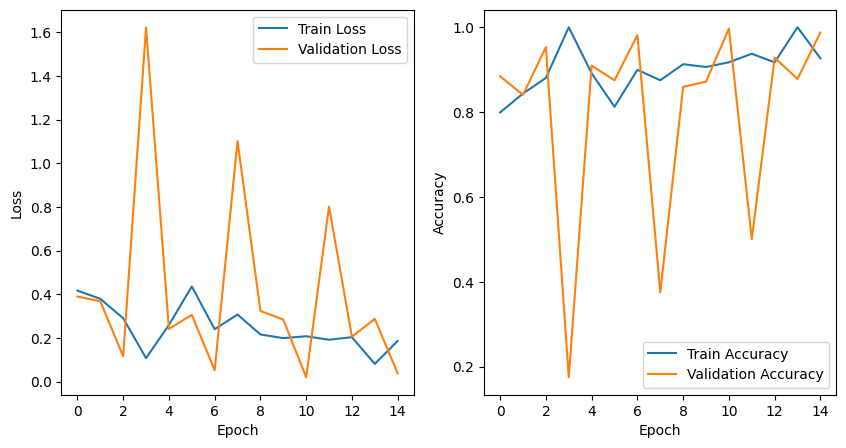

In [26]:
# Formatear el history para visualizarlo
formatted_history = prepare_history_data(history)
# Llamar a la función de plot
plot_training(formatted_history)

Con la introducción de la capa de dropout, que se añadió para intentar regularizar el modelo, prevenir el sobreajuste y ver la razón de los picos y valles abruptos, no se observa una diferencia abismal con el modelo base anteriormente entrenado. En este sentido, como la evolución de la función de pérdida de validación prácticamente no se ha suavizado frente al modelo base, si no que sigue presentando el mencionado patrón abrupto de picos y valles. Además, la *accuracy* sigue siendo prácticamente igual a la obtenida tanto en validación como en entrenamiento del modelo base (alrededor del 90%), por lo que no ha resultado en una disminución del leve overfitting oversado en el modelo anterior.

Frente a esta igual de resultados respecto al modelo anterior, resulta que el nivel de *dropout* implementado no ha resultado ser suficiente para mejorar los resultados del modelo base. Esto, nos lleva a pensar que estamos enfrentando desafíos inherentes en el entrenamiento de modelos de aprendizaje profundo. En este sentido, el fenómeno observado de los picos pronunciados y la alta variabilidad en las gráficas de validación obtenidas, pueden estar causadas por múltiples fenómenos tales como:
- Un tamaño de lote pequeño. Se ha determinado un batch size de 32 debido a la capacidad finita de computación de los equipos empleados, donde un valor mayor de batch size provocaba un error de pérdida de memoria incluso ejecutándolo en la GPU del sistema. Por tanto, en este sentido, al contar con recursos limitados nos es imposible proponer una solución.
- Falta de generalización del modelo: Si el modelo está sobreajustado al conjunto de entrenamiento, puede no generalizar bien al conjunto de validación. Esto puede resultar en picos en la gráfica de validación cuando el modelo encuentra ejemplos que no se ajustan bien a las características aprendidas del conjunto de entrenamiento. Para solventar esto, ya se ha provado en el presente notebook la introducción del *dropout*, sin obtener resultados positivos.

Frente a estos fenómenos, y con los resultados obtenidos tras la introducción del *dropout* solo nos queda la opción de investigar nuevas políticas de regularización para tratar de suavizar las curvas de validación y aumentar la capacidad de generalización del modelo.


